In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from tabular_policy_maze.maze_env import MazeEnv, MazeEnvWithDistanceReward, plot_maze

from tabular_policy_maze.reinforce import (
                train_reinforce,
                train_reinforce_with_baseline,
                train_reinforce_with_advantage,
                train_reinforce_with_advantage_entropy,
                train_reinforce_with_gae_entropy,
            )

from tabular_policy_maze.util import (
                plot_maze_with_trajectory,
                plot_steps_distribution,
            )

---
## Simple 4x4:

<Axes: >

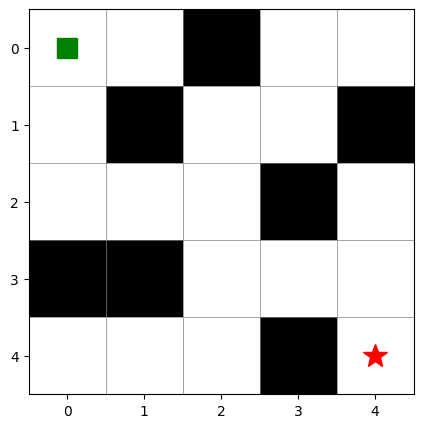

In [3]:
maze = np.array([
    [0, 0, 1, 0, 0],
    [0, 1, 0, 0, 1],
    [0, 0, 0, 1, 0],
    [1, 1, 0, 0, 0],
    [0, 0, 0, 1, 0],
])

env = MazeEnv(maze, start=(0, 0), goal=(4, 4), goal_reward=0)
plot_maze(env)

---
## Tabular REINFORCE: (no neural net)

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'Mean return')

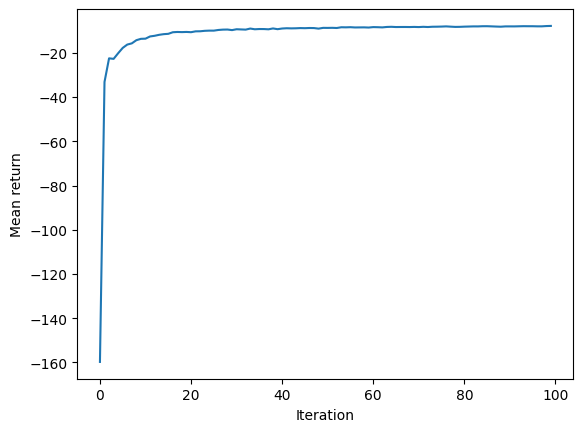

In [4]:
theta, mean_returns = train_reinforce(env, n_iter=100, n_episodes=512, alpha=0.05, gamma=1.0)

plt.plot(mean_returns)
plt.xlabel("Iteration")
plt.ylabel("Mean return")

<Axes: title={'center': 'Policy rollout  (steps: 9, reached goal)'}>

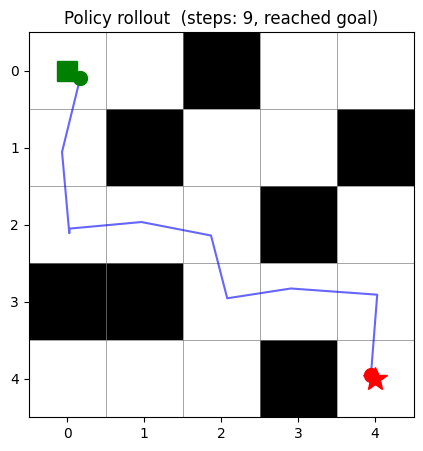

In [5]:
plot_maze_with_trajectory(env, theta, title="Policy rollout")

Sampling trajectories:   0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: title={'center': 'Steps distribution — success rate: 100.0%'}, xlabel='Steps', ylabel='Count'>

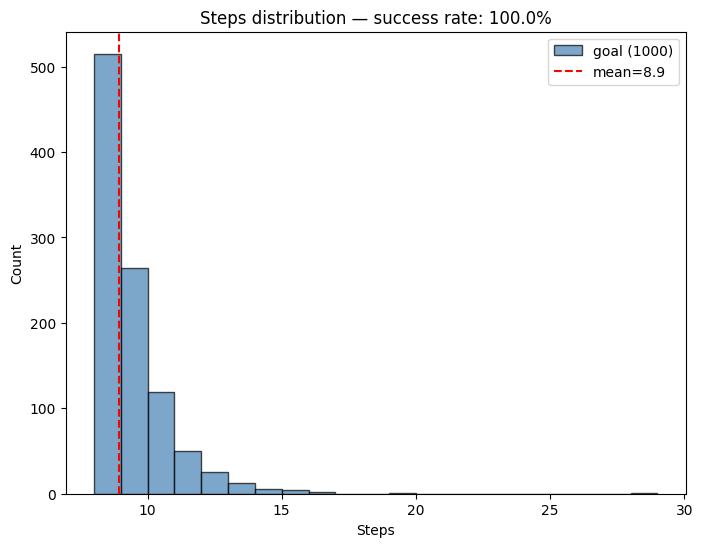

In [6]:
plot_steps_distribution(env, theta, n_trajectories=1000, figsize=(8, 6))

## With baseline

In [7]:
theta_baseline, mean_returns_baseline = train_reinforce_with_baseline(env, n_iter=100, n_episodes=512, alpha=0.05, gamma=1, alpha_v=0.01)

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'Mean return')

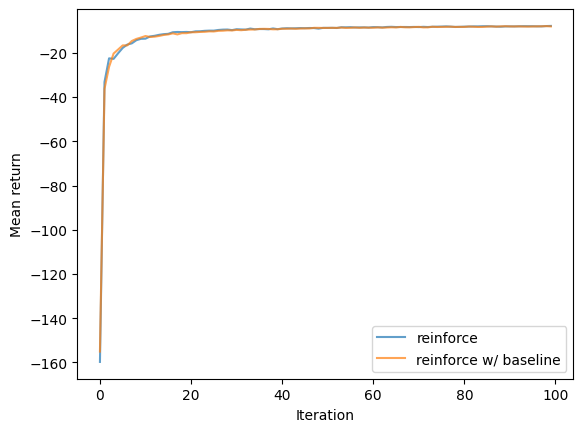

In [8]:
plt.plot(mean_returns, label='reinforce', alpha=0.7)
plt.plot(mean_returns_baseline, label='reinforce w/ baseline', alpha=0.7)
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Mean return")

Sampling trajectories:   0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: title={'center': 'Steps distribution — success rate: 100.0%'}, xlabel='Steps', ylabel='Count'>

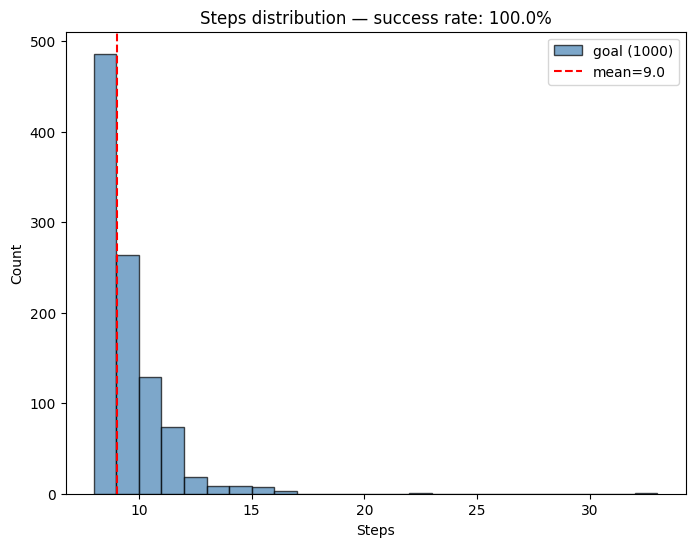

In [9]:
plot_steps_distribution(env, theta_baseline, n_trajectories=1000, figsize=(8, 6))

---
## Exploring Tabular Policy for bigger Mazes:

- Let's create function to create maze of given size with given % of obstacles:

In [10]:
from tabular_policy_maze.util import generate_maze_env, build_maze_env
from tabular_policy_maze.maze_env import MazeEnv, MazeEnvWithDistanceReward

States: 113, Actions: 4


<Axes: >

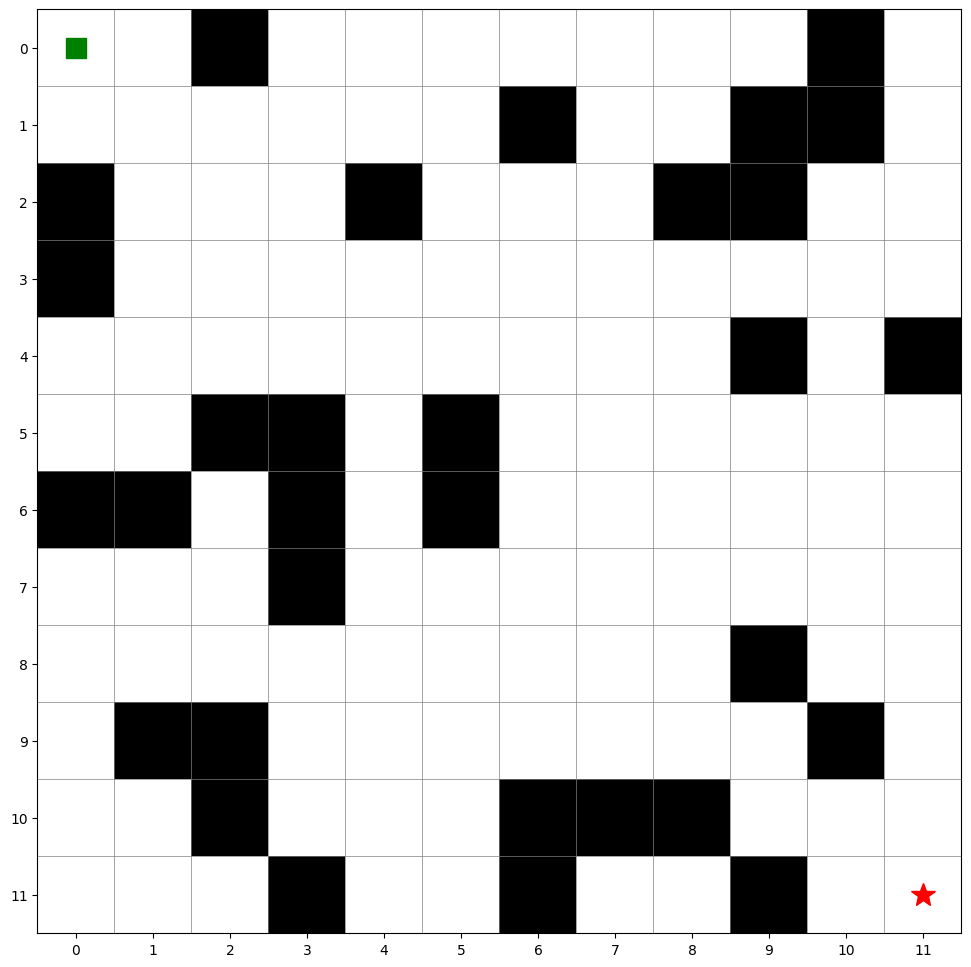

In [11]:
env = generate_maze_env(12, obstacle_pct=0.25, seed=50, max_steps=500)
print(f"States: {env.n_states}, Actions: {env.n_actions}")
plot_maze(env)

In [12]:
theta, mean_returns = train_reinforce(env, n_iter=100, n_episodes=512, alpha=0.05, gamma=1.0)

theta_baseline, mean_returns_baseline = train_reinforce_with_baseline(env, n_iter=100, n_episodes=512, alpha=0.05, gamma=1, alpha_v=0.01)

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'Mean return')

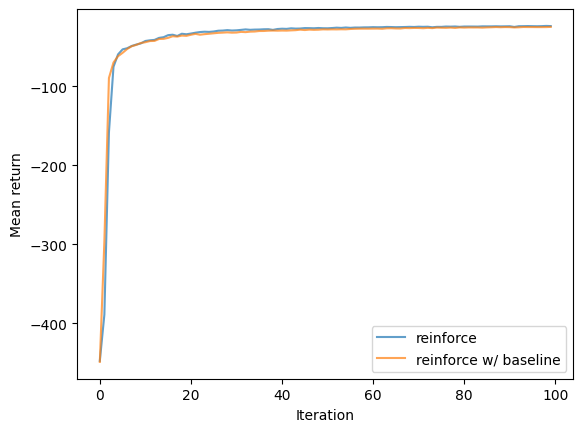

In [13]:
plt.plot(mean_returns, label='reinforce', alpha=0.7)
plt.plot(mean_returns_baseline, label='reinforce w/ baseline', alpha=0.7)
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Mean return")

<Axes: title={'center': 'Policy rollout  (steps: 24, reached goal)'}>

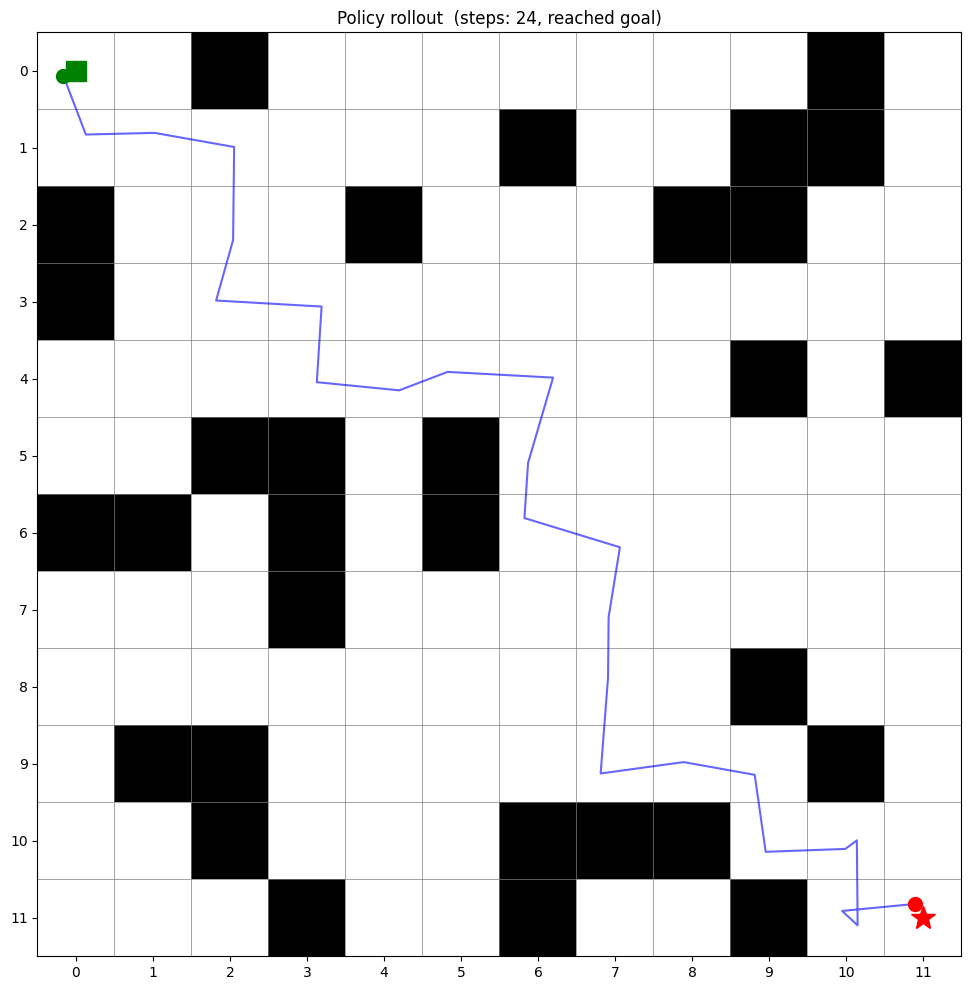

In [14]:
plot_maze_with_trajectory(env, theta, title="Policy rollout")

Sampling trajectories:   0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: title={'center': 'Steps distribution — success rate: 100.0%'}, xlabel='Steps', ylabel='Count'>

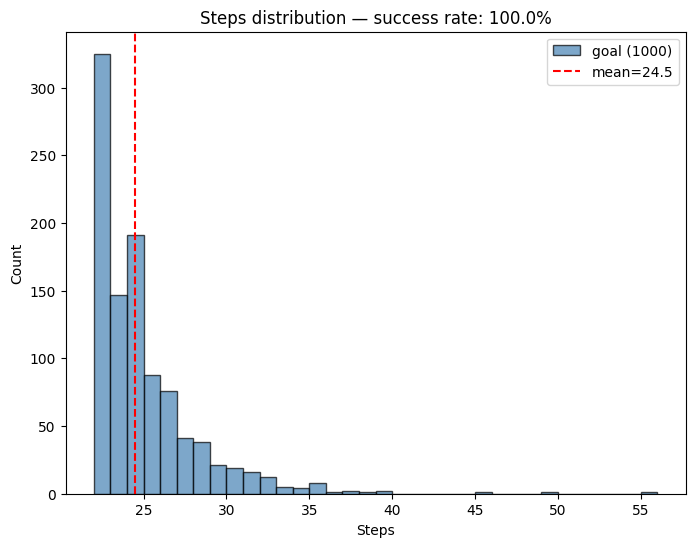

In [15]:
plot_steps_distribution(env, theta, n_trajectories=1000, figsize=(8, 6))

### Env with distance reward

In [16]:
env = build_maze_env(MazeEnvWithDistanceReward, 12, obstacle_pct=0.25, seed=50, max_steps=500)
print(f"States: {env.n_states}, Actions: {env.n_actions}")

States: 113, Actions: 4


In [17]:
theta, mean_returns = train_reinforce(env, n_iter=100, n_episodes=512, alpha=0.05, gamma=1.0)

theta_baseline, mean_returns_baseline = train_reinforce_with_baseline(env, n_iter=100, n_episodes=512, alpha=0.05, gamma=1, alpha_v=0.01)

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'Mean return')

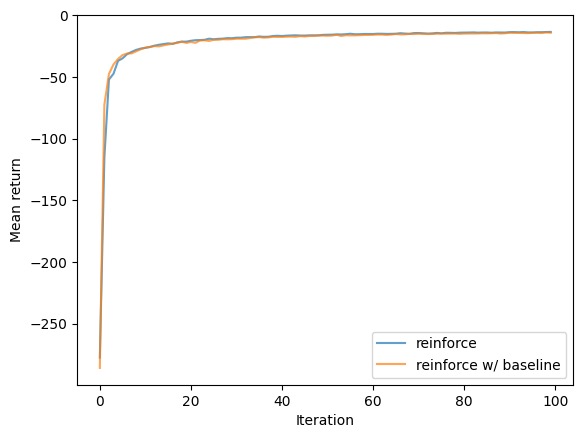

In [18]:
plt.plot(mean_returns, label='reinforce', alpha=0.7)
plt.plot(mean_returns_baseline, label='reinforce w/ baseline', alpha=0.7)
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Mean return")

Sampling trajectories:   0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: title={'center': 'Steps distribution — success rate: 100.0%'}, xlabel='Steps', ylabel='Count'>

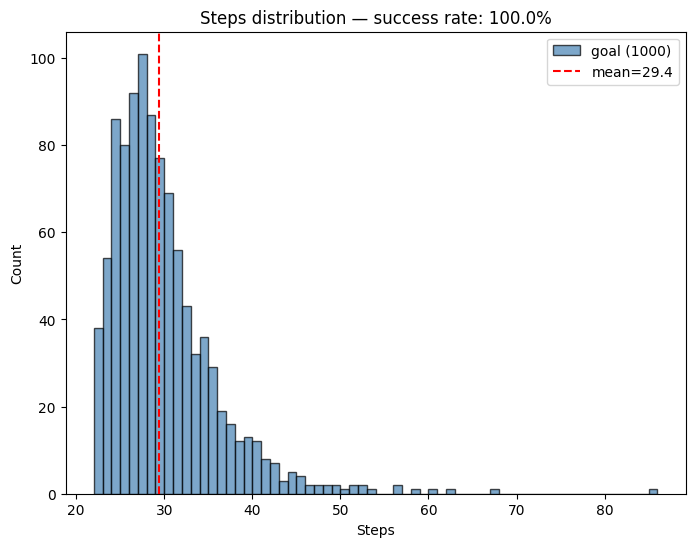

In [19]:
plot_steps_distribution(env, theta, n_trajectories=1000, figsize=(8, 6))

### Testing Andvantage and Andvantage with Entropy

In [20]:
env = generate_maze_env(12, obstacle_pct=0.25, seed=50, max_steps=500)

reinforce_with_advantage_args = {
    'n_iter': 100,
    'n_episodes': 256,
    'alpha': 1,
    'gamma': 0.999,
    'alpha_v': 0.05,
}

reinforce_with_advantage_entropy_args = {
    'n_iter': 100,
    'n_episodes': 256,
    'alpha': 1,
    'gamma': 0.999,
    'alpha_v': 0.05,
    'entropy_beta': 0.1
}

In [21]:
theta_reinforce_with_advantage, mean_returns_reinforce_with_advantage = train_reinforce_with_advantage(env, **reinforce_with_advantage_args)

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

In [22]:
theta_reinforce_with_advantage_entropy, mean_returns_reinforce_with_advantage_entropy = train_reinforce_with_advantage_entropy(env, **reinforce_with_advantage_entropy_args)

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'Mean return')

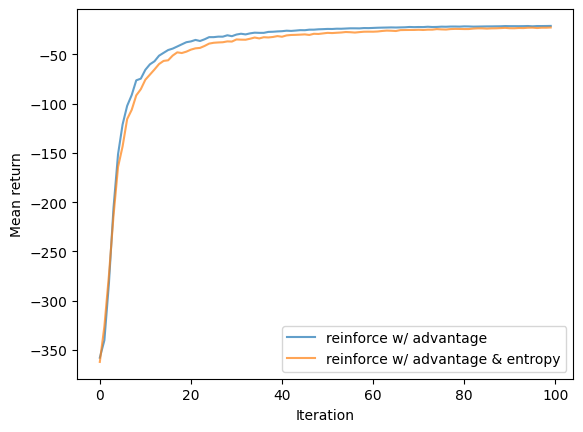

In [23]:
plt.plot(mean_returns_reinforce_with_advantage, label='reinforce w/ advantage', alpha=0.7)
plt.plot(mean_returns_reinforce_with_advantage_entropy, label='reinforce w/ advantage & entropy', alpha=0.7)
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Mean return")

Sampling trajectories:   0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: title={'center': 'Steps distribution — success rate: 100.0%'}, xlabel='Steps', ylabel='Count'>

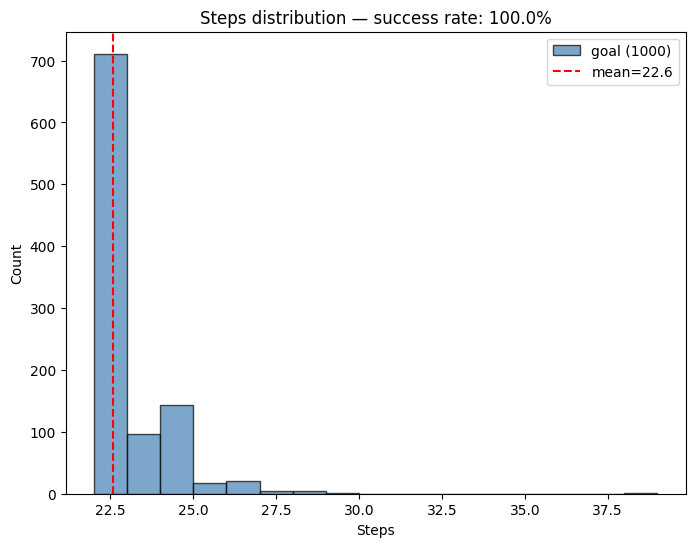

In [24]:
plot_steps_distribution(env, theta_reinforce_with_advantage, n_trajectories=1000, figsize=(8, 6))

Sampling trajectories:   0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: title={'center': 'Steps distribution — success rate: 100.0%'}, xlabel='Steps', ylabel='Count'>

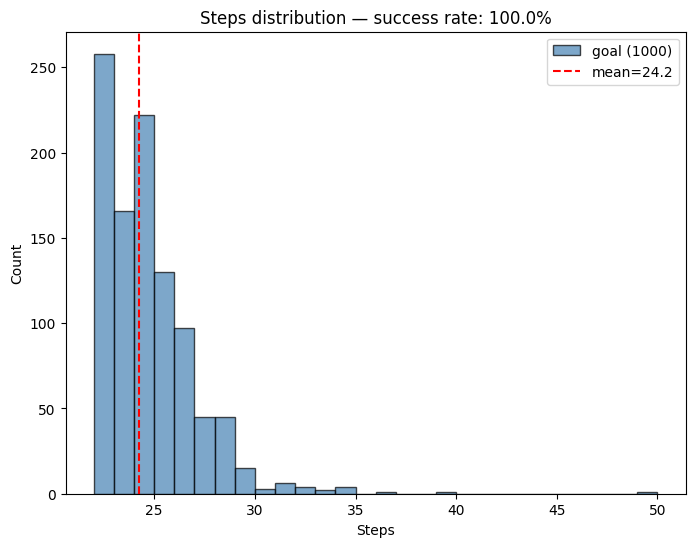

In [26]:
plot_steps_distribution(env, theta_reinforce_with_advantage_entropy, n_trajectories=1000, figsize=(8, 6))

---
## Doing evaluation across multiple seeds for given Maze parameters:

In [27]:
from tabular_policy_maze.util import benchmark

#### Standard REINFORCE with no tweaks

In [31]:
reinforce_args = {
    'n_iter': 100,
    'n_episodes': 512,
    'alpha': 0.05,
    'gamma': 1.0,
}

maze_args = {
    'size': 12,
    'obstacle_pct': 0.25,
    'max_steps': 300,
    'step_reward': -1.0,
    'goal_reward': 0.0, 
}

benchmark(
    train_method=train_reinforce,
    train_arguments=reinforce_args,
    maze_class=MazeEnv,
    maze_arguments=maze_args,
    n_seeds=10,
    n_eval=200
)

Seeds:   0%|          | 0/10 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]


Maze 12x12, obstacles=25%, seeds=10
Success rate: 50.0% ± 50.0%
Mean steps (goal only): 26.3 ± 1.6


{'n_seeds': 10,
 'avg_success_rate': np.float64(0.5),
 'std_success_rate': np.float64(0.5),
 'avg_steps': np.float64(26.274),
 'std_steps': np.float64(1.564776022311181),
 'per_seed': [{'seed': 0,
   'n_states': 112,
   'success_rate': 1.0,
   'mean_steps': np.float64(26.905),
   'final_return': -25.671875},
  {'seed': 1,
   'n_states': 106,
   'success_rate': 0.0,
   'mean_steps': inf,
   'final_return': -300.0},
  {'seed': 2,
   'n_states': 107,
   'success_rate': 1.0,
   'mean_steps': np.float64(29.045),
   'final_return': -27.8046875},
  {'seed': 3,
   'n_states': 107,
   'success_rate': 0.0,
   'mean_steps': inf,
   'final_return': -300.0},
  {'seed': 4,
   'n_states': 119,
   'success_rate': 0.0,
   'mean_steps': inf,
   'final_return': -300.0},
  {'seed': 5,
   'n_states': 111,
   'success_rate': 0.0,
   'mean_steps': inf,
   'final_return': -300.0},
  {'seed': 6,
   'n_states': 112,
   'success_rate': 1.0,
   'mean_steps': np.float64(25.135),
   'final_return': -24.43359375},
 

#### REINFORCE with baseline (based on Value Function)

In [33]:
reinforce_with_baseline_args = {
    'n_iter': 100,
    'n_episodes': 512,
    'alpha': 0.05,
    'gamma': 1.0,
    'alpha_v': 0.05,
}

maze_args = {
    'size': 12,
    'obstacle_pct': 0.25,
    'max_steps': 300,
    'step_reward': -1.0,
    'goal_reward': 0.0,
}

benchmark(
    train_method=train_reinforce_with_baseline,
    train_arguments=reinforce_with_baseline_args,
    maze_class=MazeEnv,
    maze_arguments=maze_args,
    n_seeds=10,
    n_eval=200
)

Seeds:   0%|          | 0/10 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]


Maze 12x12, obstacles=25%, seeds=10
Success rate: 100.0% ± 0.0%
Mean steps (goal only): 25.7 ± 0.8


{'n_seeds': 10,
 'avg_success_rate': np.float64(1.0),
 'std_success_rate': np.float64(0.0),
 'avg_steps': np.float64(25.670499999999997),
 'std_steps': np.float64(0.8143416052247358),
 'per_seed': [{'seed': 0,
   'n_states': 112,
   'success_rate': 1.0,
   'mean_steps': np.float64(25.12),
   'final_return': -24.255859375},
  {'seed': 1,
   'n_states': 106,
   'success_rate': 1.0,
   'mean_steps': np.float64(25.285),
   'final_return': -24.58203125},
  {'seed': 2,
   'n_states': 107,
   'success_rate': 1.0,
   'mean_steps': np.float64(27.75),
   'final_return': -26.56640625},
  {'seed': 3,
   'n_states': 107,
   'success_rate': 1.0,
   'mean_steps': np.float64(25.315),
   'final_return': -23.87890625},
  {'seed': 4,
   'n_states': 119,
   'success_rate': 1.0,
   'mean_steps': np.float64(25.225),
   'final_return': -24.42578125},
  {'seed': 5,
   'n_states': 111,
   'success_rate': 1.0,
   'mean_steps': np.float64(25.065),
   'final_return': -24.30859375},
  {'seed': 6,
   'n_states': 11

#### Maze with distant dependent reward. REINFORCE

In [39]:
reinforce_args = {
    'n_iter': 100,
    'n_episodes': 512,
    'alpha': 0.05,
    'gamma': 1.0,
}

maze_args = {
    'size': 12,
    'obstacle_pct': 0.25,
    'max_steps': 300,
    'step_reward': -1.0,
    'goal_reward': 0.0, 
}

benchmark(
    train_method=train_reinforce,
    train_arguments=reinforce_args,
    maze_class=MazeEnvWithDistanceReward,
    maze_arguments=maze_args,
    n_seeds=10,
    n_eval=200
)

Seeds:   0%|          | 0/10 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]


Maze 12x12, obstacles=25%, seeds=10
Success rate: 100.0% ± 0.0%
Mean steps (goal only): 30.9 ± 2.3


{'n_seeds': 10,
 'avg_success_rate': np.float64(1.0),
 'std_success_rate': np.float64(0.0),
 'avg_steps': np.float64(30.875999999999998),
 'std_steps': np.float64(2.331969982654151),
 'per_seed': [{'seed': 0,
   'n_states': 112,
   'success_rate': 1.0,
   'mean_steps': np.float64(30.555),
   'final_return': -13.991921164772727},
  {'seed': 1,
   'n_states': 106,
   'success_rate': 1.0,
   'mean_steps': np.float64(31.475),
   'final_return': -13.638938210227273},
  {'seed': 2,
   'n_states': 107,
   'success_rate': 1.0,
   'mean_steps': np.float64(37.555),
   'final_return': -15.362837357954547},
  {'seed': 3,
   'n_states': 107,
   'success_rate': 1.0,
   'mean_steps': np.float64(30.205),
   'final_return': -13.435280539772727},
  {'seed': 4,
   'n_states': 119,
   'success_rate': 1.0,
   'mean_steps': np.float64(29.725),
   'final_return': -13.945845170454547},
  {'seed': 5,
   'n_states': 111,
   'success_rate': 1.0,
   'mean_steps': np.float64(29.88),
   'final_return': -13.30806107

#### Maze with distant dependent reward. REINFORCE with baseline (based on Value Function)

In [34]:
reinforce_with_baseline_args = {
    'n_iter': 100,
    'n_episodes': 512,
    'alpha': 0.05,
    'gamma': 1.0,
    'alpha_v': 0.05,
}

maze_args = {
    'size': 12,
    'obstacle_pct': 0.25,
    'max_steps': 300,
    'step_reward': -1.0,
    'goal_reward': 0.0,
}

benchmark(
    train_method=train_reinforce_with_baseline,
    train_arguments=reinforce_with_baseline_args,
    maze_class=MazeEnvWithDistanceReward,
    maze_arguments=maze_args,
    n_seeds=10,
    n_eval=200
)

Seeds:   0%|          | 0/10 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]


Maze 12x12, obstacles=25%, seeds=10
Success rate: 100.0% ± 0.0%
Mean steps (goal only): 31.6 ± 1.9


{'n_seeds': 10,
 'avg_success_rate': np.float64(1.0),
 'std_success_rate': np.float64(0.0),
 'avg_steps': np.float64(31.578500000000002),
 'std_steps': np.float64(1.8812921756069685),
 'per_seed': [{'seed': 0,
   'n_states': 112,
   'success_rate': 1.0,
   'mean_steps': np.float64(30.6),
   'final_return': -13.309126420454545},
  {'seed': 1,
   'n_states': 106,
   'success_rate': 1.0,
   'mean_steps': np.float64(32.03),
   'final_return': -14.093306107954545},
  {'seed': 2,
   'n_states': 107,
   'success_rate': 1.0,
   'mean_steps': np.float64(36.17),
   'final_return': -14.676313920454547},
  {'seed': 3,
   'n_states': 107,
   'success_rate': 1.0,
   'mean_steps': np.float64(30.83),
   'final_return': -13.43856534090909},
  {'seed': 4,
   'n_states': 119,
   'success_rate': 1.0,
   'mean_steps': np.float64(30.485),
   'final_return': -13.53995028409091},
  {'seed': 5,
   'n_states': 111,
   'success_rate': 1.0,
   'mean_steps': np.float64(32.225),
   'final_return': -14.5768821022727

In [48]:
reinforce_with_advantage_args = {
    'n_iter': 100,
    'n_episodes': 512,
    'alpha': 1.0,
    'gamma': 1.0,
    'alpha_v': 0.05,
}

maze_args = {
    'size': 12,
    'obstacle_pct': 0.25,
    'max_steps': 300,
    'step_reward': -1.0,
    'goal_reward': 0.0,
}

benchmark(
    train_method=train_reinforce_with_advantage,
    train_arguments=reinforce_with_advantage_args,
    maze_class=MazeEnv,
    maze_arguments=maze_args,
    n_seeds=10,
    n_eval=200
)

Seeds:   0%|          | 0/10 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]


Maze 12x12, obstacles=25%, seeds=10
Success rate: 100.0% ± 0.0%
Mean steps (goal only): 22.9 ± 0.7


{'n_seeds': 10,
 'avg_success_rate': np.float64(1.0),
 'std_success_rate': np.float64(0.0),
 'avg_steps': np.float64(22.886499999999998),
 'std_steps': np.float64(0.6897537604101914),
 'per_seed': [{'seed': 0,
   'n_states': 112,
   'success_rate': 1.0,
   'mean_steps': np.float64(22.53),
   'final_return': -21.478515625},
  {'seed': 1,
   'n_states': 106,
   'success_rate': 1.0,
   'mean_steps': np.float64(22.57),
   'final_return': -21.716796875},
  {'seed': 2,
   'n_states': 107,
   'success_rate': 1.0,
   'mean_steps': np.float64(24.88),
   'final_return': -23.771484375},
  {'seed': 3,
   'n_states': 107,
   'success_rate': 1.0,
   'mean_steps': np.float64(22.525),
   'final_return': -21.693359375},
  {'seed': 4,
   'n_states': 119,
   'success_rate': 1.0,
   'mean_steps': np.float64(22.855),
   'final_return': -21.9609375},
  {'seed': 5,
   'n_states': 111,
   'success_rate': 1.0,
   'mean_steps': np.float64(23.13),
   'final_return': -21.892578125},
  {'seed': 6,
   'n_states': 1

In [49]:
reinforce_with_advantage_entropy_args = {
    'n_iter': 100,
    'n_episodes': 512,
    'alpha': 1.0,
    'gamma': 1.0,
    'alpha_v': 0.05,
    'entropy_beta': 0.1
}

maze_args = {
    'size': 12,
    'obstacle_pct': 0.25,
    'max_steps': 300,
    'step_reward': -1.0,
    'goal_reward': 0.0,
}

benchmark(
    train_method=train_reinforce_with_advantage_entropy,
    train_arguments=reinforce_with_advantage_entropy_args,
    maze_class=MazeEnv,
    maze_arguments=maze_args,
    n_seeds=4,
    n_eval=200
)

Seeds:   0%|          | 0/4 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]


Maze 12x12, obstacles=25%, seeds=4
Success rate: 100.0% ± 0.0%
Mean steps (goal only): 25.0 ± 1.3


{'n_seeds': 4,
 'avg_success_rate': np.float64(1.0),
 'std_success_rate': np.float64(0.0),
 'avg_steps': np.float64(25.0425),
 'std_steps': np.float64(1.3266711159891882),
 'per_seed': [{'seed': 0,
   'n_states': 112,
   'success_rate': 1.0,
   'mean_steps': np.float64(24.265),
   'final_return': -23.1171875},
  {'seed': 1,
   'n_states': 106,
   'success_rate': 1.0,
   'mean_steps': np.float64(24.11),
   'final_return': -23.2890625},
  {'seed': 2,
   'n_states': 107,
   'success_rate': 1.0,
   'mean_steps': np.float64(27.33),
   'final_return': -26.091796875},
  {'seed': 3,
   'n_states': 107,
   'success_rate': 1.0,
   'mean_steps': np.float64(24.465),
   'final_return': -23.39453125}],
 'size': 12,
 'obstacle_pct': 0.25,
 'max_steps': 300,
 'step_reward': -1.0,
 'goal_reward': 0.0,
 'n_iter': 100,
 'n_episodes': 512,
 'alpha': 1.0,
 'gamma': 1.0,
 'alpha_v': 0.05,
 'entropy_beta': 0.1}

### How big of a Maze we can solve?

In [ ]:
maze_sizes = [12, 16, 20, 25, 30, 40]
n_seeds = 3
n_eval = 200

base_maze_args = {
    'obstacle_pct': 0.25,
    'max_steps': 300,
    'step_reward': -1.0,
    'goal_reward': 0.0,
}

reinforce_args = {
    'n_iter': 100,
    'n_episodes': 512,
    'alpha': 0.05,
    'gamma': 1.0,
}

reinforce_with_baseline_args = {
    'n_iter': 100,
    'n_episodes': 512,
    'alpha': 0.05,
    'gamma': 1.0,
    'alpha_v': 0.05,
}

reinforce_with_advantage_args = {
    'n_iter': 100,
    'n_episodes': 512,
    'alpha': 1.0,
    'gamma': 1.0,
    'alpha_v': 0.05,
}

methods = {
    "REINFORCE": {
        "train_method": train_reinforce,
        "train_arguments": reinforce_args,
        "maze_class": MazeEnv,
    },
    "REINFORCE + baseline": {
        "train_method": train_reinforce_with_baseline,
        "train_arguments": reinforce_with_baseline_args,
        "maze_class": MazeEnv,
    },
    "REINFORCE + distance env": {
        "train_method": train_reinforce,
        "train_arguments": reinforce_args,
        "maze_class": MazeEnvWithDistanceReward,
    },
    "REINFORCE + baseline + distance env": {
        "train_method": train_reinforce_with_baseline,
        "train_arguments": reinforce_with_baseline_args,
        "maze_class": MazeEnvWithDistanceReward,
    },
    "REINFORCE + advantage": {
        "train_method": train_reinforce_with_advantage,
        "train_arguments": reinforce_with_advantage_args,
        "maze_class": MazeEnv,
    },
    "REINFORCE + advantage + distance env": {
        "train_method": train_reinforce_with_advantage,
        "train_arguments": reinforce_with_advantage_args,
        "maze_class": MazeEnvWithDistanceReward,
    },
}

results = {
    name: {"maze_size": [], "success_rate": [], "mean_steps": []}
    for name in methods
}

for size in maze_sizes:
    maze_args = dict(base_maze_args)
    maze_args["size"] = size

    for name, cfg in methods.items():
        summary = benchmark(
            train_method=cfg["train_method"],
            train_arguments=cfg["train_arguments"],
            maze_class=cfg["maze_class"],
            maze_arguments=maze_args,
            n_seeds=n_seeds,
            n_eval=n_eval
        )

        results[name]["maze_size"].append(size)
        results[name]["success_rate"].append(summary["avg_success_rate"]) 
        results[name]["mean_steps"].append(summary["avg_steps"])          


plt.figure(figsize=(8, 5))
for name, d in results.items():
    x = np.array(d["maze_size"])
    y = np.array(d["mean_steps"], dtype=float)

    mask = np.isfinite(y)
    plt.plot(x[mask], y[mask], marker="o", label=name)

plt.xlabel("Maze Size")
plt.ylabel("Mean steps (goal only)")
plt.title(f"Mean steps vs Maze size (seeds={n_seeds}, eval={n_eval})")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


plt.figure(figsize=(8, 5))
for name, d in results.items():
    x = np.array(d["maze_size"])
    y = np.array(d["success_rate"], dtype=float)
    plt.plot(x, y, marker="o", label=name)

plt.xlabel("Maze Size")
plt.ylabel(f"Average success rate ({n_seeds} seeds)")
plt.ylim(-0.02, 1.02)
plt.title(f"Success rate vs Maze size (seeds={n_seeds}, eval={n_eval})")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Seeds:   0%|          | 0/3 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]